In [127]:
import numpy as np
import matplotlib.pyplot as plt

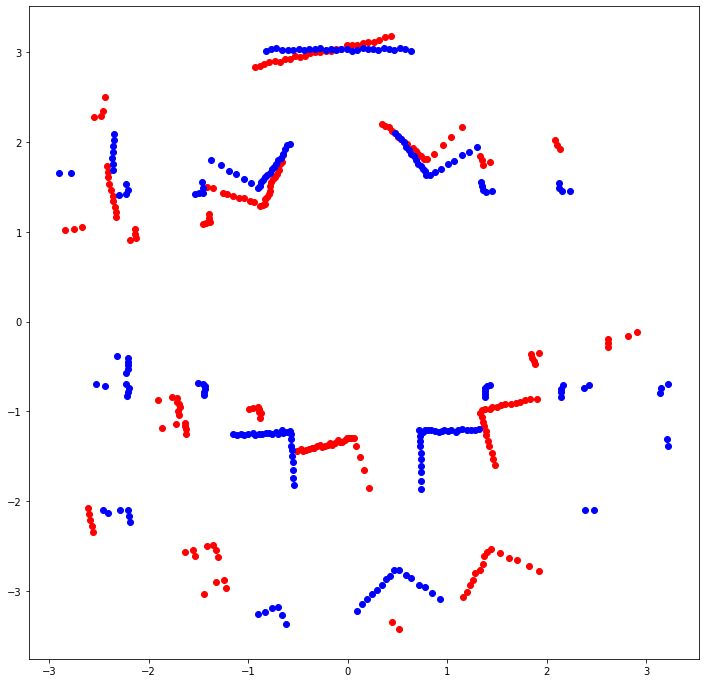

In [499]:
x = np.load("../../../scan_0.npy")
y = np.load("../../../scan_20.npy")

x_org = x
y_org = y

fig = plt.figure(figsize=(12,12))
plt.scatter(x[:,0], x[:,1], c = 'r')
plt.scatter(y[:,0], y[:,1], c = 'b')
plt.show()

In [406]:
def transform(x: np.ndarray, R: np.ndarray, t: np.ndarray) -> np.ndarray:
    """ rotate and move a vector, not sure transform is the right word """
    assert R.shape == (3,3) and t.shape == (3,) and x.shape[1] == 3, "Wrong shapes"
    return (R @ x.T + t[:, None]).T

In [167]:
from sklearn.neighbors import NearestNeighbors

max_iters = 100

R = np.eye(3)
t = np.zeros(3)
distance_threshold = 1.0 # should ideally not be a parameter, makes it hard to tune
tolerance = 0.2  # idk a good value

nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(y)

distances, indices = nbrs.kneighbors(transform(x,R,t))
print(x.shape)
print(y.shape)
print(distances.shape)
print(indices.shape)

(220, 3)
(218, 3)
(220, 1)
(220, 1)


In [132]:
# from collections import defaultdict

# closest = {}

# # indices: for every point in x get the index of the closest point in y
# distances, indices = nbrs.kneighbors(transform(x,R,t))

# x_new = np.zeros_like(y)

# for p, i in zip(x, indices.ravel()):
#     # the closest dist to y index
#     dist = np.linalg.norm(p - y[i])
    
#     if not (i in closest):
#         closest[i] = dist
#         x_new[i] = p
#     elif dist < closest[i]:
#         closest[i] = dist
#         x_new[i] = p

In [135]:
# mask = ~(x_new == 0).all(axis= 1)

# x_new = x_new[mask]
# y_new = y[mask]

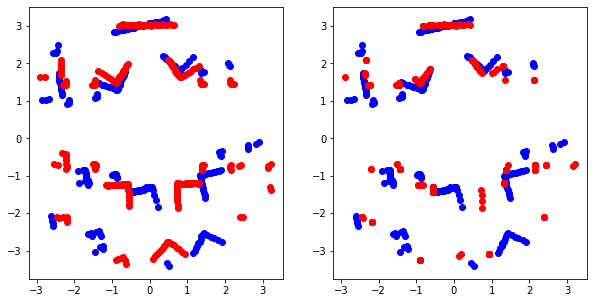

In [172]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].scatter(x[:,0], x[:,1], c = 'b')
axs[0].scatter(y[:,0], y[:,1], c = 'r')

y_hat = y[indices].squeeze()

# for i in range(len(x)):
#     axs[1].plot([x[i, 0], y_hat[i, 0]], [x[i, 1], y_hat[i, 1]], 'k--')

axs[1].scatter(x[:,0], x[:,1], c = 'b')
axs[1].scatter(y_hat[:,0], y_hat[:,1], c = 'r')

plt.show()

In [407]:
def weighted_average(values: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
    """ Get the centre of mass for a set of values, """
    assert weights is None or values.shape[0] == weights.shape[0]
    return np.average(values, weights=weights, axis=0)

def compute_transformation_params(x: np.ndarray, y: np.ndarray, p: np.ndarray = None) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform a single step of ICP where perfect corresponence is assumed. 
    Returns a rotation matrix and translation vector.
    """
    assert x.shape == y.shape
    if p is None:
        p = np.ones(len(x))
    # Get the centres of mass
    x_0 = weighted_average(x, p)
    y_0 = weighted_average(y, p)

    # Calculate cross covariance matrix
    H = (y_0 - y).T @ ((x_0 - x) * p[:, None])

    # Do SVD
    U, _S, Vt = np.linalg.svd(H)    

    # Calculate rotation matrix and translation vector
    R = U @ Vt # Vh.T @ U.T # 
    t = y_0 - R @ x_0

    return R, t



In [500]:
R = np.eye(3)
t = np.zeros(3)

nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(y_org)

x = x_org
y = y_org

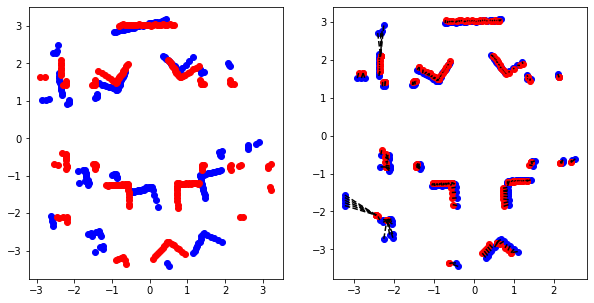

In [508]:
x = transform(x,R,t)

distances, indices = nbrs.kneighbors(x)

y_hat = y_org[indices].squeeze()
R, t = compute_transformation_params(x, y_hat)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].scatter(x_org[:,0], x_org[:,1], c = 'b')
axs[0].scatter(y_org[:,0], y_org[:,1], c = 'r')

for i in range(len(x)):
    axs[1].plot([x[i, 0], y_hat[i, 0]], [x[i, 1], y_hat[i, 1]], 'k--')

axs[1].scatter(x[:,0], x[:,1], c = 'b')
axs[1].scatter(y_hat[:,0], y_hat[:,1], c = 'r')

plt.show()